# ASU Online Physical Chemistry Laboratory (CHM 343): Acoustic Interferometer Data Analysis and Plotting

*Jeffery Yarger, jyarger@proton.me*

Fall 2023

This juypter notebook is written in python and designed to be web browser compatible using CoLaboratory ([Google CoLab](https://colab.research.google.com/)) and public [GitHub](https://github.com/) repositories.


[![Made withJupyter](https://img.shields.io/badge/Made%20with-Jupyter-orange?style=for-the-badge&logo=Jupyter)](https://jupyter.org/try)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CHM343/Acoustic_Interferometer/blob/main/Notebooks/Remote_Acoustic_Interferometer_Data_Analysis_2023.ipynb)

[![made-with-python](https://img.shields.io/badge/Made%20with-Python-1f425f.svg)](https://www.python.org/)
[![GitHub](https://badgen.net/badge/icon/github?icon=github&label)](https://github.com)
[![official JetBrains project](http://jb.gg/badges/official.svg)](https://confluence.jetbrains.com/display/ALL/JetBrains+on+GitHub)

# Introduction

An acoustic interferometer has been designed by [Jeff Yarger](https://scholar.google.com/citations?user=C-x0iiEAAAAJ&hl=en) to be used for remote ('cloud') labs as part of developing [ASU Online](https://asuonline.asu.edu/) Physical Chemistry Labs (ASU Online CHM 343, [BioPchem Public Website](https://biopchem.education/)).  The basic concept is that different gases can be purged through a tube that has a speaker and microphone for measuring acoustic interferometry, allowing the speed of sound of various gases to be determined.  The speed of sound is directly related to thermodynamic properties, i.e., the compressibility (and heat capacity ratio) [1-3].   This notebook assumes that sound data has been collected (currently using [Audacity](https://www.audacityteam.org/) or the web browser application, [Wavacity](https://wavacity.com/)) and the recorded sound has been Fourier Transformed (FT), resulting in a frequency spectrum (and these spectra saved in a text format).

[1] [BioPchem.Education blog post](https://biopchem.education/2022/01/17/acoustic-interferometry-pchem-cloud-lab/).

[2] [Heat Capacity and the Speed of Sound, Blog Post (2020)](https://biopchem.education/2022/01/17/acoustic-interferometry-pchem-cloud-lab/).

[3] “Determining the Speed of Sound and Heat Capacity Ratios of Gases by Acoustic Interferometry” - J. Chem. Educ. 2017, 94, 12, 1995–1998. (https://doi.org/10.1021/acs.jchemed.7b00526)

# Import Python Libraries

First import the python libraries needed for reading in data, plotting the data and performing any necessary data analysis.

In [15]:
#IO and Basic Python Libraries
import os
import io
import zipfile as zf
import requests
import shutil
from IPython import display
from six.moves.urllib.request import urlopen

#!pip install -q ipywidgets
from google.colab import widgets

#Data Analysis and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
import matplotlib.patches as patches
from scipy.signal import find_peaks
from scipy import stats
from scipy.stats import t

#Audio File Python Libraries
import librosa
import soundfile as sf
from scipy.io import wavfile

# Acoustic Interferometry

The acoustic interferometer is a DIY setup where a 1/2 to 2 inch diameter tube with a length between 1-3 foot is capped on each end with a speaker, microphone and gas inlet and outlets. Audio data was collected using audacity (where audacity allows playing sound to the speaker and recording from the microphone). The most common way to record acoustic interference is to generate and play white noise using the speaker and record the resulting sound at the microphone.  The resulting sound data is Fourier Transformed (FT) to a frequency spectrum, where the resonant nodes can be easily observed (in audacity this can be done by going to Analyze > Plot Spectrum). Spectral Data was saved as a text file and uploaded to a public GitHub repository.  Its this GitHub data that will be read, analyzed and plotted in this Juypter Notebook (CoLab Notebook).

Before using this notebook, upload data to a public GitHub repository (in this example we will use the CHM343 (asuchm343@gmail.com) Acoustic Interferometer public repository with the data in a Data subfolder on the repository).  Now you can read the data files directly from GitHub to any Juypter or Python notebook using pandas.  Hint, make sure to read the raw data file. The exported spectral text files created by audacity are basic frequency (Hz) vs Level (dB) with a tab deliminator.  The first line is the data column labels and all subsequent lines are the x-y data (2 columns, Frequency and Level).

## Instrument and Experimental Details

A remote acoustic interferometer was setup at ASU (ISTB1 L2-63, the Magnetic Resonance Research Center Lab).  The current setup (for 2023_08_15 - 2023_09_15) uses a 2 foot long 0.75 inch diameter clear polycarbonate tube with 1/2 inch thick square end caps that have drilled holes for the earbud (speaker), lav mic (microphone), needle gas inlet (on earbud side), and small hole for gas exit (microphone side).  The microphone is on one side and the speaker (earbud) on the other side.  An arduino microcontroller is setup with solonoid valves to allow computer control of 4 different input gases.  A flow meter is included after the solonoid manufold and a PZT camera is available for a live view of the instrument and flow meter to monitor the gas flow into the tube.  Audacity was used to generate sound that was played through the speaker as well as record the resulting sound generated through the gas filled tube through a microphone.  Sound data was collected for both white noise (11025 Hz) and for linear frequency chirp sound input (1-11025 Hz over 55.125 sec).  The recorded sound collected at the microphone used a **100 ms buffer and -130 ms delay**, which is often practically necessary when digitizing sound data.  This has the practical effect of offsetting the gas sound data by 130 ms in the time domain (when compared to the input sound).  Furthermore, each gas was purged for 20 sec prior to running and was flowing at 2 LPM for 60 sec during the sound data collection.  Sound data was recorded for 60+ seconds so that the gas flow stopping can be observed and background sound data with no gas flow or sound is recorded to so that one can evaluate any ambient lab sound.
![Acoustic Interferometer Setup](https://github.com/CHM343/Acoustic_Interferometer/raw/main/ScreenShot/2023_08_26_Remote_Acoustic_Interferometer_Setup.jpeg)

## Read in Audio Data and Spectral Data from Public GitHub Repository

In [34]:
GitHub_Repository = 'CHM343/Acoustic_Interferometer/' # @param ["CHM343/Acoustic_Interferometer/", "BioPchem/", "YargerLab/Data/"] {allow-input: true}
Noise_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-01' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-01", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-01", "Option 3"] {allow-input: true}
Gas1_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-02' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-02", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-02", "Option 3"] {allow-input: true}
Gas2_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-03' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-03", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-03", "Option 3"] {allow-input: true}
Gas3_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-04' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-04", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-04", "Option 3"] {allow-input: true}
Gas4_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-05' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-05", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-05", "Option 3"] {allow-input: true}

Chirp_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-06' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-06", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-02", "Option 3"] {allow-input: true}
Gas1_Chirp_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-07' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-07", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-04", "Option 3"] {allow-input: true}
Gas2_Chirp_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-08' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-08", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-06", "Option 3"] {allow-input: true}
Gas3_Chirp_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-09' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-09", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-08", "Option 3"] {allow-input: true}
Gas4_Chirp_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-11' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-11", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-10", "Option 3"] {allow-input: true}

Bkgrd_Filename = '2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-12' # @param ["2023_08_29_Remote_AI_White_Noise_30sec_Chirp_55sec_11kHz_4Gases-12", "2023_08_29_Remote_AI_White_Noise_Chirp_11kHz_4Gases-17", "3rd option"] {allow-input: true}

GitHub_URL_Wav = 'https://github.com/'
GitHub_URL_Txt = 'https://raw.githubusercontent.com/'
GitHub_Repo_URL_Wav = 'raw/main/Data/'
GitHub_Repo_URL_Txt = 'main/Data/'

URL_White_Noise_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Noise_Filename + '.wav'
URL_Gas1_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas1_Filename + '.wav'
URL_Gas2_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas2_Filename + '.wav'
URL_Gas3_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas3_Filename + '.wav'
URL_Gas4_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas4_Filename + '.wav'

URL_Chirp_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Chirp_Filename + '.wav'
URL_Gas1_Chirp_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas1_Chirp_Filename + '.wav'
URL_Gas2_Chirp_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas2_Chirp_Filename + '.wav'
URL_Gas3_Chirp_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas3_Chirp_Filename + '.wav'
URL_Gas4_Chirp_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Gas4_Chirp_Filename + '.wav'

URL_Bkgrd_Sound = GitHub_URL_Wav + GitHub_Repository + GitHub_Repo_URL_Wav + Bkgrd_Filename + '.wav'
URL_Bkgrd_Spectrum = GitHub_URL_Txt + GitHub_Repository + GitHub_Repo_URL_Txt + Bkgrd_Filename + 's' + '.txt'

URL_White_Noise_Spectrum = GitHub_URL_Txt + GitHub_Repository + GitHub_Repo_URL_Txt + Noise_Filename + 's' + '.txt'
URL_Gas1_Spectrum = GitHub_URL_Txt + GitHub_Repository + GitHub_Repo_URL_Txt + Gas1_Filename + 's' + '.txt'
URL_Gas2_Spectrum = GitHub_URL_Txt + GitHub_Repository + GitHub_Repo_URL_Txt + Gas2_Filename + 's' + '.txt'
URL_Gas3_Spectrum = GitHub_URL_Txt + GitHub_Repository + GitHub_Repo_URL_Txt + Gas3_Filename + 's' + '.txt'
URL_Gas4_Spectrum = GitHub_URL_Txt + GitHub_Repository + GitHub_Repo_URL_Txt + Gas4_Filename + 's' + '.txt'


In [35]:
# Read in audacity exported sound data from public CHM343 GitHub Repository using soundfile python library.
# Input White Noise Sound File
White_Noise_Sound_Data, White_Noise_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_White_Noise_Sound).read()))
White_Noise_Sound_Time = np.arange(0,len(White_Noise_Sound_Data))/White_Noise_Sound_SampleRate
White_Noise_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':White_Noise_Sound_Time, 'Amplitude':White_Noise_Sound_Data})
# Gas #1 White Noise Sound Data
Gas1_White_Noise_Sound_Data, Gas1_White_Noise_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas1_Sound).read()))
Gas1_White_Noise_Sound_Time = np.arange(0,len(Gas1_White_Noise_Sound_Data))/Gas1_White_Noise_Sound_SampleRate
Gas1_White_Noise_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas1_White_Noise_Sound_Time, 'Amplitude':Gas1_White_Noise_Sound_Data})
# Gas #2 White Noise Sound Data
Gas2_White_Noise_Sound_Data, Gas2_White_Noise_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas2_Sound).read()))
Gas2_White_Noise_Sound_Time = np.arange(0,len(Gas2_White_Noise_Sound_Data))/Gas2_White_Noise_Sound_SampleRate
Gas2_White_Noise_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas2_White_Noise_Sound_Time, 'Amplitude':Gas2_White_Noise_Sound_Data})
# Gas #3 White Noise Sound Data
Gas3_White_Noise_Sound_Data, Gas3_White_Noise_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas3_Sound).read()))
Gas3_White_Noise_Sound_Time = np.arange(0,len(Gas3_White_Noise_Sound_Data))/Gas3_White_Noise_Sound_SampleRate
Gas3_White_Noise_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas3_White_Noise_Sound_Time, 'Amplitude':Gas3_White_Noise_Sound_Data})
# Gas #4 White Noise Sound Data
Gas4_White_Noise_Sound_Data, Gas4_White_Noise_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas4_Sound).read()))
Gas4_White_Noise_Sound_Time = np.arange(0,len(Gas4_White_Noise_Sound_Data))/Gas4_White_Noise_Sound_SampleRate
Gas4_White_Noise_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas4_White_Noise_Sound_Time, 'Amplitude':Gas4_White_Noise_Sound_Data})

# Input Chirp Sound File
Chirp_Sound_Data, Chirp_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Chirp_Sound).read()))
Chirp_Sound_Time = np.arange(0,len(Chirp_Sound_Data))/Chirp_Sound_SampleRate
Chirp_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Chirp_Sound_Time, 'Amplitude':Chirp_Sound_Data})
# Gas #1 Chirp Sound Data
Gas1_Chirp_Sound_Data, Gas1_Chirp_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas1_Chirp_Sound).read()))
Gas1_Chirp_Sound_Time = np.arange(0,len(Gas1_Chirp_Sound_Data))/Gas1_Chirp_Sound_SampleRate
Gas1_Chirp_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas1_Chirp_Sound_Time, 'Amplitude':Gas1_Chirp_Sound_Data})
# Gas #2 Chirp Sound Data
Gas2_Chirp_Sound_Data, Gas2_Chirp_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas2_Chirp_Sound).read()))
Gas2_Chirp_Sound_Time = np.arange(0,len(Gas2_Chirp_Sound_Data))/Gas2_Chirp_Sound_SampleRate
Gas2_Chirp_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas2_Chirp_Sound_Time, 'Amplitude':Gas2_Chirp_Sound_Data})
# Gas #3 Chirp Sound Data
Gas3_Chirp_Sound_Data, Gas3_Chirp_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas3_Chirp_Sound).read()))
Gas3_Chirp_Sound_Time = np.arange(0,len(Gas3_Chirp_Sound_Data))/Gas3_Chirp_Sound_SampleRate
Gas3_Chirp_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas3_Chirp_Sound_Time, 'Amplitude':Gas3_Chirp_Sound_Data})
# Gas #4 Chirp Sound Data
Gas4_Chirp_Sound_Data, Gas4_Chirp_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Gas4_Chirp_Sound).read()))
Gas4_Chirp_Sound_Time = np.arange(0,len(Gas4_Chirp_Sound_Data))/Gas4_Chirp_Sound_SampleRate
Gas4_Chirp_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Gas4_Chirp_Sound_Time, 'Amplitude':Gas4_Chirp_Sound_Data})

# Background Sound File - No Sound and No Gas Flow
Bkgrd_Sound_Data, Bkgrd_Sound_SampleRate = sf.read(io.BytesIO(urlopen(URL_Bkgrd_Sound).read()))
Bkgrd_Sound_Time = np.arange(0,len(Bkgrd_Sound_Data))/Bkgrd_Sound_SampleRate
Bkgrd_Sound_Time_Data_Combine = pd.DataFrame({'Time (sec)':Bkgrd_Sound_Time, 'Amplitude':Bkgrd_Sound_Data})


# Read in audacity exported spectral data (and first line header label) from public CHM343 GitHub Repository using pandas.
# White Noise Spectrum
White_Noise_Spectrum = pd.read_table(URL_White_Noise_Spectrum, sep = "\t" ,header=0)
# Gas #1 White Noise Spectrum
Gas1_Spectrum = pd.read_table(URL_Gas1_Spectrum, sep = "\t" ,header=0)
# Gas #2 White Noise Spectrum
Gas2_Spectrum = pd.read_table(URL_Gas2_Spectrum, sep = "\t" ,header=0)
# Gas #3 White Noise Spectrum
Gas3_Spectrum = pd.read_table(URL_Gas3_Spectrum, sep = "\t" ,header=0)
# Gas #4 White Noise Spectrum
Gas4_Spectrum = pd.read_table(URL_Gas4_Spectrum, sep = "\t" ,header=0)
# Background Spectrum - No Sound and No Gas Flow
Bkgrd_Spectrum = pd.read_table(URL_Bkgrd_Spectrum, sep = "\t" ,header=0)

## Visualization of Sound Data

Acoustic interferometry plays sound through a speaker (commonly white noise, chirp sound or a specific single frequency sound) into a tube (fixed length, or variable length which is often called a Kundt's tube) filled with the gas of interest and records the resulting sound that results from sound waves constructively and destructively interfering through the gas filled tube using a microphone.  Hence, the raw data are sound files.  It is common in the case of white noise acoustic interferometry to convert the raw sound data (time vs amplitude) to a spectrum (frequency vs amplitude) using Fourier Transforms (and typically window function filtering).

It is always good practice to look at the raw data before any data manipulation.  Below is a stacked plot (using [MatPlotLib](https://matplotlib.org/)) of the raw sound data (white noise and chirp) that was exported in audacity as wav files and uploaded to GitHub.  

### Plot for White Noise Sound Data

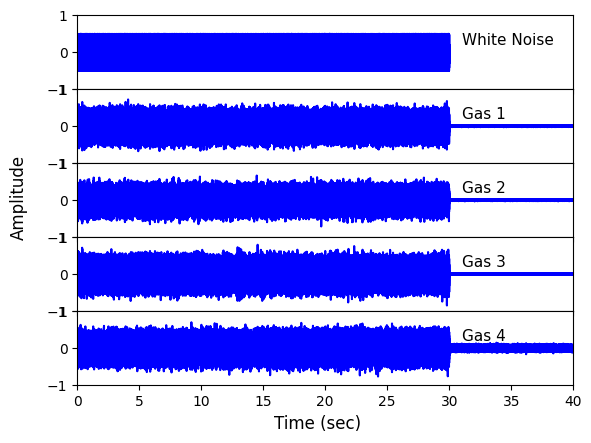

In [36]:
# @title
# Initializes a matplotlib subplot for white noise sound data (There is a 100 ms delay and lag in the Gas Sound Data)
fig = plt.figure()
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].plot(White_Noise_Sound_Time_Data_Combine['Time (sec)'], White_Noise_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'White Noise Sound Input')
axs[1].plot(Gas1_White_Noise_Sound_Time_Data_Combine['Time (sec)'], Gas1_White_Noise_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 1 White Noise')
axs[2].plot(Gas2_White_Noise_Sound_Time_Data_Combine['Time (sec)'], Gas2_White_Noise_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 2 White Noise')
axs[3].plot(Gas3_White_Noise_Sound_Time_Data_Combine['Time (sec)'], Gas3_White_Noise_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 3 White Noise')
axs[4].plot(Gas4_White_Noise_Sound_Time_Data_Combine['Time (sec)'], Gas4_White_Noise_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 4 White Noise')

#set the plotting axis limits and x- and y-axis labels
plt.axis([0,40,-1,1])
#plt.xlabel('Frequency (Hz)')
#set_shared_ylabel(axs, 'Level (dB)')
#plt.ylabel('Level (dB)')
fig.supxlabel('Time (sec)')
fig.supylabel('Amplitude')

#Annotate Plot with text
axs[0].text(31, 0.2, 'White Noise', fontsize=11)
axs[1].text(31, 0.2, 'Gas 1', fontsize=11)
axs[2].text(31, 0.2, 'Gas 2', fontsize=11)
axs[3].text(31, 0.2, 'Gas 3', fontsize=11)
axs[4].text(31, 0.2, 'Gas 4', fontsize=11)

#Changing the Font Size Using rcParams
plt.rc('axes', labelsize=12)        # Controls Axes Labels
plt.rc('xtick', labelsize=12)       # Controls x Tick Labels
plt.rc('ytick', labelsize=8)       # Controls y Tick Labels
plt.rcParams['lines.linewidth'] = 0.05   # Controls linewidth for all Plots

#### Example figure caption
Figure 1 - White noise sound (top) at an amplitude of 0.5 for a duration of 30 sec, which is played through a speaker (earbud), while sound is recorded using a microphone (lav mic) at the opposite end of a ~24 in tube with one of the 4 gases flowing at 2 liters per minute (Gas 1-4).  There is a 100 ms delay in the recorded sound data of each gas.  The gas flow ends around 35 sec, and the sound is recorded for around 1 minute.  This results in data recorded during gas flow and white noise sound (0-30 sec), with gas flowing and no white noise sound (30-35 sec), and with no gas flow or white noise sound (> 35 sec). The Fourier transform (FT) of the resulting sound data results in frequency spectral data, which can be used to observe the acoustic interferometry resonance frequency modes that depend on the length of the tube (which is constant) and the speed of sound of the gas in the tube (which varies with the composition of the gas that is in the tube).

### Plot for Chirp Sound Data

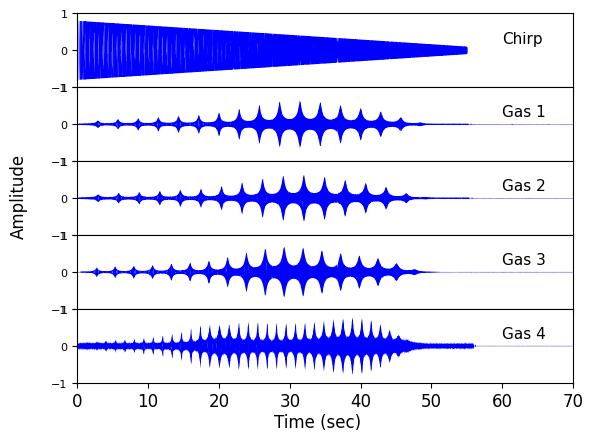

In [37]:
# @title
# Initializes a matplotlib subplot for chirp sound data (There is a 100 ms delay and lag in sound data)
fig = plt.figure()
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].plot(Chirp_Sound_Time_Data_Combine['Time (sec)'], Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Chirp Sound Input')
axs[1].plot(Gas1_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas1_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 1 Chirp')
axs[2].plot(Gas2_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas2_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 2 Chirp')
axs[3].plot(Gas3_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas3_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 3 Chirp')
axs[4].plot(Gas4_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas4_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 4 Chirp')


#set the plotting axis limits and x- and y-axis labels
plt.axis([0,70,-1,1])
#plt.xlabel('Frequency (Hz)')
#set_shared_ylabel(axs, 'Level (dB)')
#plt.ylabel('Level (dB)')
fig.supxlabel('Time (sec)')
fig.supylabel('Amplitude')

#Annotate Plot with text
axs[0].text(60, 0.2, 'Chirp', fontsize=11)
axs[1].text(60, 0.2, 'Gas 1', fontsize=11)
axs[2].text(60, 0.2, 'Gas 2', fontsize=11)
axs[3].text(60, 0.2, 'Gas 3', fontsize=11)
axs[4].text(60, 0.2, 'Gas 4', fontsize=11)

#Changing the Font Size Using rcParams
plt.rc('axes', labelsize=12)        # Controls Axes Labels
plt.rc('xtick', labelsize=12)       # Controls x Tick Labels
plt.rc('ytick', labelsize=8)       # Controls y Tick Labels
plt.rcParams['lines.linewidth'] = 0.05   # Controls linewidth for all Plots

#Plot a legend and show the plot in this notebook
#plt.legend()
#plt.show()

## Use the Python SciPy Library to Find Resonance Peaks in the Chirp Sound Data

The python [scipy](https://docs.scipy.org/doc/scipy/index.html) library has a [signals](https://docs.scipy.org/doc/scipy/reference/signal.html) component with a [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) function that makes determining the resonance sound times for each gas during a linear chirp input more automated and convenient.

In [69]:
# @title
# Python code using SciPy library for determining resonance sound 'peaks' in acoustic interferometry linear chirp sound data.

gas1_chirp_resonances = find_peaks(Gas1_Chirp_Sound_Time_Data_Combine['Amplitude'], threshold=0.005, distance = 20000, height=0.05, prominence = 0.1)
gas2_chirp_resonances = find_peaks(Gas2_Chirp_Sound_Time_Data_Combine['Amplitude'], threshold=0.005, distance = 20000, height=0.05, prominence = 0.1)
gas3_chirp_resonances = find_peaks(Gas3_Chirp_Sound_Time_Data_Combine['Amplitude'], threshold=0.001, distance = 20000, height=0.05, prominence = 0.1)
gas4_chirp_resonances = find_peaks(Gas4_Chirp_Sound_Time_Data_Combine['Amplitude'], threshold=0.1, distance = 10000, height=0.1, prominence = 0.3)

Gas1_Time = Gas1_Chirp_Sound_Time_Data_Combine['Time (sec)']
Gas2_Time = Gas2_Chirp_Sound_Time_Data_Combine['Time (sec)']
Gas3_Time = Gas3_Chirp_Sound_Time_Data_Combine['Time (sec)']
Gas4_Time = Gas4_Chirp_Sound_Time_Data_Combine['Time (sec)']

gas1_resonance_list = Gas1_Time[gas1_chirp_resonances[0]]
gas2_resonance_list = Gas2_Time[gas2_chirp_resonances[0]]
gas3_resonance_list = Gas3_Time[gas3_chirp_resonances[0]]
gas4_resonance_list = Gas4_Time[gas4_chirp_resonances[0]]

gas1_resonance_array = np.array((round(gas1_resonance_list,2)))
gas2_resonance_array = np.array((round(gas2_resonance_list,2)))
gas3_resonance_array = np.array((round(gas3_resonance_list,2)))
gas4_resonance_array = np.array((round(gas4_resonance_list,2)))

gas1_restable = pd.DataFrame(gas1_resonance_array, columns=["Time (sec)"])
gas2_restable = pd.DataFrame(gas2_resonance_array, columns=["Time (sec)"])
gas3_restable = pd.DataFrame(gas3_resonance_array, columns=["Time (sec)"])
gas4_restable = pd.DataFrame(gas4_resonance_array, columns=["Time (sec)"])

gas1_restable['Node'] = np.arange(1, gas1_restable.shape[0] + 1)
gas2_restable['Node'] = np.arange(1, gas2_restable.shape[0] + 1)
gas3_restable['Node'] = np.arange(1, gas3_restable.shape[0] + 1)
gas4_restable['Node'] = np.arange(1, gas4_restable.shape[0] + 1)

gas1_restable = gas1_restable.loc[:,['Node','Time (sec)']]
gas2_restable = gas2_restable.loc[:,['Node','Time (sec)']]
gas3_restable = gas3_restable.loc[:,['Node','Time (sec)']]
gas4_restable = gas4_restable.loc[:,['Node','Time (sec)']]

#print('Peak location Frequency (Hz)')
#print('')
#print(round(gas1_peak_list,2))

### Plot the Linear Chirp Sound Gases Data and Scipy find_peaks values

Its easier to visualize the results of the resonance peak finding by plotting the sound data and vertical dotted lines for each of the 'resonances' determined from the find_peak scipy function.

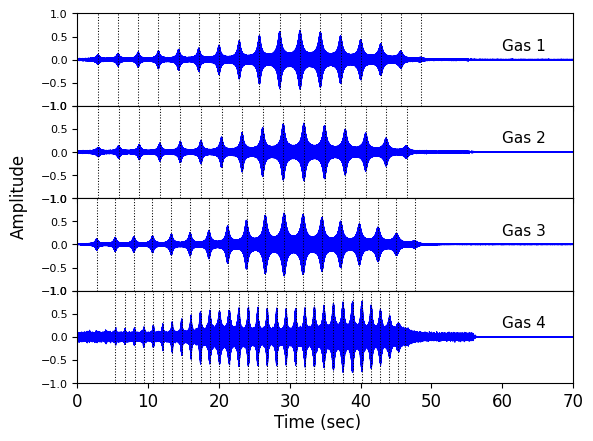

In [70]:
# @title
# Initializes a matplotlib subplot (plot all 4 gases and find_peak frequencies)
fig = plt.figure()
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].plot(Gas1_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas1_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 1 Chirp')
axs[1].plot(Gas2_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas2_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 2 Chirp')
axs[2].plot(Gas3_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas3_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 3 Chirp')
axs[3].plot(Gas4_Chirp_Sound_Time_Data_Combine['Time (sec)'], Gas4_Chirp_Sound_Time_Data_Combine['Amplitude'], 'b-', label = 'Gas 4 Chirp')


#set the plotting axis limits and x- and y-axis labels
plt.axis([0,70,-1,1])
#plt.xlabel('Frequency (Hz)')
#set_shared_ylabel(axs, 'Level (dB)')
#plt.ylabel('Level (dB)')
fig.supxlabel('Time (sec)')
fig.supylabel('Amplitude')

#For Loop to add the peak_list determined using SciPy find_peaks and add as verticle dotted lines to the sound resonance plots
for y in range(len(gas1_chirp_resonances[0])):
  axs[0].axvline(x = gas1_resonance_list.iloc[y], color='k',linestyle='dotted')
for y in range(len(gas2_chirp_resonances[0])):
  axs[1].axvline(x = gas2_resonance_list.iloc[y], color='k',linestyle='dotted')
for y in range(len(gas3_chirp_resonances[0])):
  axs[2].axvline(x = gas3_resonance_list.iloc[y], color='k',linestyle='dotted')
for y in range(len(gas4_chirp_resonances[0])):
  axs[3].axvline(x = gas4_resonance_list.iloc[y], color='k',linestyle='dotted')

#Annotate Plot with text
axs[0].text(60, 0.2, 'Gas 1', fontsize=11)
axs[1].text(60, 0.2, 'Gas 2', fontsize=11)
axs[2].text(60, 0.2, 'Gas 3', fontsize=11)
axs[3].text(60, 0.2, 'Gas 4', fontsize=11)

#Changing the Font Size Using rcParams
plt.rc('axes', labelsize=12)        # Controls Axes Labels
plt.rc('xtick', labelsize=12)       # Controls x Tick Labels
plt.rc('ytick', labelsize=8)       # Controls y Tick Labels
plt.rcParams['lines.linewidth'] = 0.75   # Controls linewidth for all Plots

#Plot a legend and show the plot in this notebook
#plt.legend()
plt.show()

## Plot of Spectral Data (for White Noise sound)

The common method for converting the sound data into a spectral frequency data is using a Fourier Transform.  The resonance frequencies can be determined from the peak of each spectral resonance node. Acoustic interferometry data is collected for several gases.  Make a stacked plot of all the spectral data.  This provides a quick visual means of looking at all the spectral data together and is starting point for a report figure.  This plot uses the python [MatPlotLib](https://matplotlib.org/) library.

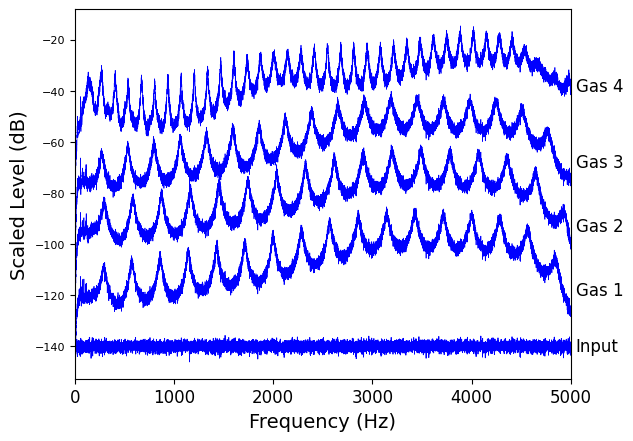

In [76]:
# @title
# Initialize matplotlib subplot layout
fig, ax = plt.subplots()

# Set general font size
plt.rcParams['font.size'] = '11'

ax.plot(White_Noise_Spectrum['Frequency (Hz)'], White_Noise_Spectrum['Level (dB)']-90, linewidth=0.6, color = 'blue', label = 'Noise')
ax.plot(Gas1_Spectrum['Frequency (Hz)'], Gas1_Spectrum['Level (dB)']-45, linewidth=0.5, color = 'blue', label = 'Gas 1')
ax.plot(Gas2_Spectrum['Frequency (Hz)'], Gas2_Spectrum['Level (dB)']-20, linewidth=0.5, color = 'blue', label = 'Gas 2')
ax.plot(Gas3_Spectrum['Frequency (Hz)'], Gas3_Spectrum['Level (dB)'], linewidth=0.5, color = 'blue', label = 'Gas 3')
ax.plot(Gas4_Spectrum['Frequency (Hz)'], Gas4_Spectrum['Level (dB)']+25, linewidth=0.5, color = 'blue', label = 'Gas 4')

# Plot x and y axis min/max limits for plot
plt.xlim(0, 5000)
#plt.ylim(0, 15000000)

#plt.title("$^1$H NMR of Cannabidiol (CBD)")
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.ylabel("Scaled Level (dB)", fontsize=14)

# plot legend and axes
#ax.legend(loc = 'upper left', fontsize=9)
#ax.get_yaxis().set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# Annotate Plot with text
ax.text(5050, -40, 'Gas 4', fontsize=12)
ax.text(5050, -70, 'Gas 3', fontsize=12)
ax.text(5050, -95, 'Gas 2', fontsize=12)
ax.text(5050, -120, 'Gas 1', fontsize=12)
ax.text(5050, -142, 'Input', fontsize=12)

# Display the Plot
plt.show()

## Use the Python SciPy Library to Find Peaks in the Spectral Data

The python [scipy](https://docs.scipy.org/doc/scipy/index.html) library has a [signals](https://docs.scipy.org/doc/scipy/reference/signal.html) component with a [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) function that makes determining the resonance frequencies more automated and convenient.

In [87]:
# @title
# python code using SciPy library for extracting resonance 'peak' locations in acoustic interferometry white noise spectral data

gas1_peaks = find_peaks(Gas1_Spectrum['Level (dB)'], rel_height=150, distance = 200, prominence = 15)
gas2_peaks = find_peaks(Gas2_Spectrum['Level (dB)'], rel_height=150, distance = 200, prominence = 15)
gas3_peaks = find_peaks(Gas3_Spectrum['Level (dB)'], rel_height=150, distance = 200, prominence = 15)
gas4_peaks = find_peaks(Gas4_Spectrum['Level (dB)'], rel_height=100, distance = 100, prominence = 14)

Gas1_Frequency = Gas1_Spectrum['Frequency (Hz)']
Gas2_Frequency = Gas2_Spectrum['Frequency (Hz)']
Gas3_Frequency = Gas3_Spectrum['Frequency (Hz)']
Gas4_Frequency = Gas4_Spectrum['Frequency (Hz)']

gas1_peak_list = Gas1_Frequency[gas1_peaks[0]]
gas2_peak_list = Gas2_Frequency[gas2_peaks[0]]
gas3_peak_list = Gas3_Frequency[gas3_peaks[0]]
gas4_peak_list = Gas4_Frequency[gas4_peaks[0]]

gas1_peak_array = np.array((round(gas1_peak_list,2)))
gas2_peak_array = np.array((round(gas2_peak_list,2)))
gas3_peak_array = np.array((round(gas3_peak_list,2)))
gas4_peak_array = np.array((round(gas4_peak_list,2)))

gas1_peaktable = pd.DataFrame(gas1_peak_array, columns=["Frequency (Hz)"])
gas2_peaktable = pd.DataFrame(gas2_peak_array, columns=["Frequency (Hz)"])
gas3_peaktable = pd.DataFrame(gas3_peak_array, columns=["Frequency (Hz)"])
gas4_peaktable = pd.DataFrame(gas4_peak_array, columns=["Frequency (Hz)"])

gas1_peaktable['Node'] = np.arange(1, gas1_peaktable.shape[0] + 1)
gas2_peaktable['Node'] = np.arange(1, gas2_peaktable.shape[0] + 1)
gas3_peaktable['Node'] = np.arange(1, gas3_peaktable.shape[0] + 1)
gas4_peaktable['Node'] = np.arange(1, gas4_peaktable.shape[0] + 1)

gas1_peaktable = gas1_peaktable.loc[:,['Node','Frequency (Hz)']]
gas2_peaktable = gas2_peaktable.loc[:,['Node','Frequency (Hz)']]
gas3_peaktable = gas3_peaktable.loc[:,['Node','Frequency (Hz)']]
gas4_peaktable = gas4_peaktable.loc[:,['Node','Frequency (Hz)']]

#print('Peak location Frequency (Hz)')
#print('')
#print(round(gas1_peak_list,2))

### Plot the Combine Spectral Data and Scipy find_peaks positions

Its easier to visualize the results of the resonance peak finding by plotting the spectral data and vertical dotted lines for each of the 'peaks' determined from the find_peak scipy function.  The plotting uses MatPlotLib again.

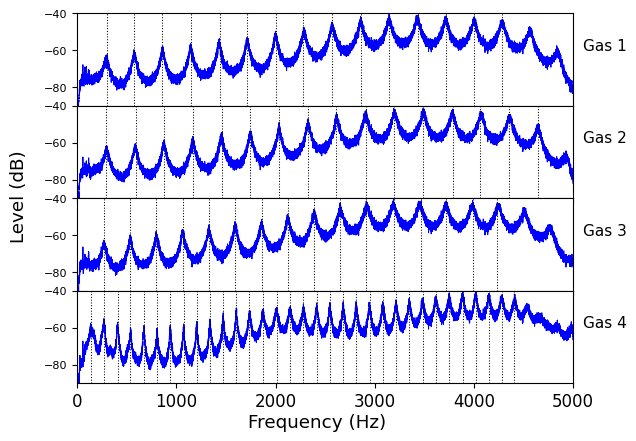

In [88]:
# @title
# Initializes a matplotlib subplot (plot all 4 gases and find_peak frequencies)
fig = plt.figure()
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].plot(Gas1_Spectrum['Frequency (Hz)'], Gas1_Spectrum['Level (dB)'], 'b-', label = 'Gas 1')
axs[1].plot(Gas2_Spectrum['Frequency (Hz)'], Gas2_Spectrum['Level (dB)'], 'b-', label = 'Gas 2')
axs[2].plot(Gas3_Spectrum['Frequency (Hz)'], Gas3_Spectrum['Level (dB)'], 'b-', label = 'Gas 3')
axs[3].plot(Gas4_Spectrum['Frequency (Hz)'], Gas4_Spectrum['Level (dB)'], 'b-', label = 'Gas 4')

#set the plotting axis limits and x- and y-axis labels
plt.axis([0,5000,-90,-40])
#plt.xlabel('Frequency (Hz)')
#set_shared_ylabel(axs, 'Level (dB)')
#plt.ylabel('Level (dB)')
fig.supxlabel('Frequency (Hz)')
fig.supylabel('Level (dB)')

#For Loop to add the peak_list determined using SciPy find_peaks and add as verticle dotted lines to the spectrum plot
for y in range(len(gas1_peaks[0])):
  axs[0].axvline(x = gas1_peak_list.iloc[y], color='k',linestyle='dotted')
for y in range(len(gas2_peaks[0])):
  axs[1].axvline(x = gas2_peak_list.iloc[y], color='k',linestyle='dotted')
for y in range(len(gas3_peaks[0])):
  axs[2].axvline(x = gas3_peak_list.iloc[y], color='k',linestyle='dotted')
for y in range(len(gas4_peaks[0])):
  axs[3].axvline(x = gas4_peak_list.iloc[y], color='k',linestyle='dotted')

#Annotate Plot with text
axs[0].text(5100, -60, 'Gas 1', fontsize=11)
axs[1].text(5100, -60, 'Gas 2', fontsize=11)
axs[2].text(5100, -60, 'Gas 3', fontsize=11)
axs[3].text(5100, -60, 'Gas 4', fontsize=11)

#Changing the Font Size Using rcParams
plt.rc('axes', labelsize=12)        # Controls Axes Labels
plt.rc('xtick', labelsize=12)       # Controls x Tick Labels
plt.rc('ytick', labelsize=8)       # Controls y Tick Labels
plt.rcParams['lines.linewidth'] = 0.75   # Controls linewidth for all Plots

#Show the plot in this notebook
plt.show()

# Data Analysis of Gas Acoustic Interferometry

The resonance frequencies ($ν$) are related to the the node number ($n = 1, 2, 3, …$) by the speed of sound ($c$) and the length of the acoustic interferometer tube ($L$):
<br><br>
$\nu = \left( \frac{c}{2L} \right) n$
<br><br>
Therefore, a linear fit of resonance frequencies ($ν$) and node number ($n$) gives a slope of $\left( \frac{c}{2L} \right)$ and a y-intercept of zero.  Hence, if you accurately know the speed of sound for the gas, you can determine the length of the acoustic interferometer resonance tube ($L$).  This length is constant and does not change.  So, using a gas with a well known speed of sound allows the length of the tube to be accurately determined.  Once the length of the tube has been determined using one or more gases with a well known speed of sound, we can now use this length to determine the speed of sound of any gases with an unknown speed of sound.  

In the current acoustic interferometer setup (2023_07_28), we have Gas-1 connected to compressed air, Gas-2 connected to a tank of Argon (Ar), and Gas-3 connected to a tank of carbon dioxide (CO$_2$).  All three of these have well known sound velocities.  Using several gases to calibrate the acoustic interferometer tube length also provides statistics for error analysis in the determination of the tube length ($L$).  Furthermore, we can look at the capped acoustic interferometer tube and roughly measure the tube length with a ruler and we know that if we are doing the data analysis correctly, we should calculate a length that is around 2 ft (24 in or 0.6096 m).

Gas-4 is an 'unknown' gas (the unknown gas will be changed periodically and will typically be a common [refrigerant gas](https://en.wikipedia.org/wiki/Refrigerant), e.g., R134a, HFO-1234yf, R290), where we will use the calculated length of the acoustic interferometer tube and determine the sound velocity of this gas.  We can use the relationship between the sound velocity and ratio of the heat capacities to further calculate thermodynamic properties of this gas.  


## Fit and Plot the Combine Gas Resonance Frequency Data
The resonance frequencies determined from the find_peak scipy function is plotted for each gas versus the resonance or node number.  This should be linear and the slope is related to the speed of sound (and the length of the acoustic interferometer tube).  The spectral data is derived from the white noise sound datasets (a similar analysis and plot can be done for the chirp datasets).

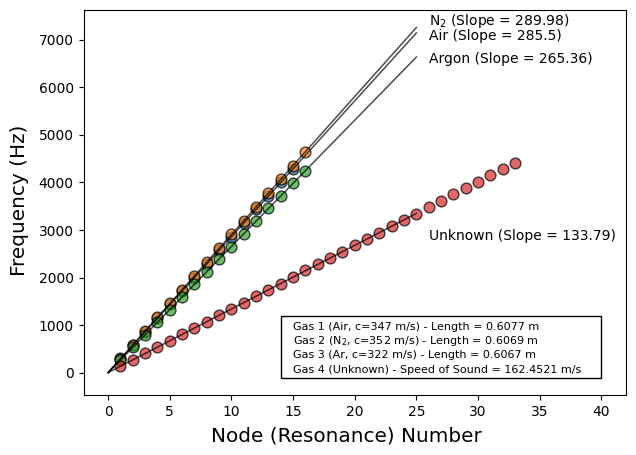

In [97]:
# @title
# Initialize plot layout
fig, ax = plt.subplots(figsize = (7, 5))

# Set general font size
plt.rcParams['font.size'] = '12'

# Set X and Y Axis Labels for subPlots
fig.supxlabel('Node (Resonance) Number')
fig.supylabel('Frequency (Hz)')

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(10)

# Add scatter plots
ax.scatter(gas1_peaktable['Node'], gas1_peaktable['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas2_peaktable['Node'], gas2_peaktable['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas3_peaktable['Node'], gas3_peaktable['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas4_peaktable['Node'], gas4_peaktable['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b1, a1 = np.polyfit(gas1_peaktable['Node'], gas1_peaktable['Frequency (Hz)'], deg=1)
b2, a2 = np.polyfit(gas2_peaktable['Node'], gas2_peaktable['Frequency (Hz)'], deg=1)
b3, a3 = np.polyfit(gas3_peaktable['Node'], gas3_peaktable['Frequency (Hz)'], deg=1)
b4, a4 = np.polyfit(gas4_peaktable['Node'], gas4_peaktable['Frequency (Hz)'], deg=1)

# Speed of Sound for Gases 1 (Air), 2 (N2) and 3 (Ar) in m/s.
c1 = 347
c2 = 352
c3 = 322

# Determine the Acoustic Interferometer resonance tube length (L) for Gases 1 (air), 2 (Ar) and 3 (CO2) in m/s.
l1 = c1/(2*b1)
l2 = c2/(2*b2)
l3 = c3/(2*b3)

# Determine the Speed of Sound (c) for Gases 4 (R134a) in m/s.
c4 = ((l1+l2+l3)/3)*(2*b4)

# Create sequence of 10 numbers from 298 to 365
xseq = np.linspace(0, 25, num=26)

# Plot regression line
ax.plot(xseq, a1 + b1 * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a2 + b2 * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a3 + b3 * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a4 + b4 * xseq, alpha=0.7, color="k", lw=1.1)

#Annotate Plot with text
ax.text(26, 7000, 'Air (Slope = {})'.format(round(b1,2)), fontsize=10)
ax.text(26, 7300, 'N$_2$ (Slope = {})'.format(round(b2,2)), fontsize=10)
ax.text(26, 6500, 'Argon (Slope = {})'.format(round(b3,2)), fontsize=10)
ax.text(26, 2800, 'Unknown (Slope = {})'.format(round(b4,2)), fontsize=10)

ax.text(15, 900, 'Gas 1 (Air, c=347 m/s) - Length = {} m'.format(round(l1,4)), fontsize=8)
ax.text(15, 600, 'Gas 2 (N$_2$, c=352 m/s) - Length = {} m'.format(round(l2,4)), fontsize=8)
ax.text(15, 300, 'Gas 3 (Ar, c=322 m/s) - Length = {} m'.format(round(l3,4)), fontsize=8)
ax.text(15, 0, 'Gas 4 (Unknown) - Speed of Sound = {} m/s'.format(round(c4,4)), fontsize=8)

# Create a Rectangle patch
rect = patches.Rectangle((14, -100), 26, 1300, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

#Show the plot in this notebook
plt.show()

## Error Analysis

Last component that needs to be done is to determine the statistical error associated with the data analysis (primarily the linear regression).  This is most commonly seen using the LINEST function in excel or google sheets.  The primary meteric we would like to obtain is the 95 $\%$ confidence in $\Delta L$ and/or $\Delta c$, which can then be used to report the values +/- this delta value.  Using SciPy stat a linear regression and statistical analysis is performed.  The coefficient of determination (R-squared) is determined for each linear regression fit and the 95% confidence interval on slope and intercept is calculated.

In [98]:
# @title
# Error Analysis - White Noise Sound Data (Frequency)

# Linear Regression using SciPy Stat Library
linearregression_gas1 = stats.linregress(gas1_peaktable['Node'], gas1_peaktable['Frequency (Hz)'])
linearregression_gas2 = stats.linregress(gas2_peaktable['Node'], gas2_peaktable['Frequency (Hz)'])
linearregression_gas3 = stats.linregress(gas3_peaktable['Node'], gas3_peaktable['Frequency (Hz)'])
linearregression_gas4 = stats.linregress(gas4_peaktable['Node'], gas4_peaktable['Frequency (Hz)'])

# Print R-squared values for each of the linear regression fits
print(f"Linear Regression R-squared")
print(f"Gas 1 - {linearregression_gas1.rvalue**2:.6f}")
print(f"Gas 2 - {linearregression_gas2.rvalue**2:.6f}")
print(f"Gas 3 - {linearregression_gas3.rvalue**2:.6f}")
print(f"Gas 4 - {linearregression_gas4.rvalue**2:.6f}")
print(f" ")


# Two-sided inverse Students t-distribution, p - probability, df - degrees of freedom
tinv = lambda p, df: abs(t.ppf(p/2, df))

print(f"95% Confidence Level (+/-)")
print(f"__________________________")
ts1 = tinv(0.05, len(gas1_peaktable['Node'])-2)
print(f"Gas 1")
print(f"slope = {linearregression_gas1.slope:.2f} +/- {ts1*linearregression_gas1.stderr:.2f}")
print(f"y-intercept = {linearregression_gas1.intercept:.2f}"
      f" +/- {ts1*linearregression_gas1.intercept_stderr:.2f}")
print(f" ")

ts2 = tinv(0.05, len(gas2_peaktable['Node'])-2)
print(f"Gas 2")
print(f"slope = {linearregression_gas2.slope:.2f} +/- {ts1*linearregression_gas2.stderr:.2f}")
print(f"y-intercept = {linearregression_gas2.intercept:.2f}"
      f" +/- {ts1*linearregression_gas2.intercept_stderr:.2f}")
print(f" ")

ts3 = tinv(0.05, len(gas3_peaktable['Node'])-2)
print(f"Gas 3")
print(f"slope = {linearregression_gas3.slope:.2f} +/- {ts1*linearregression_gas3.stderr:.2f}")
print(f"y-intercept = {linearregression_gas3.intercept:.2f}"
      f" +/- {ts1*linearregression_gas3.intercept_stderr:.2f}")
print(f" ")

ts4 = tinv(0.05, len(gas4_peaktable['Node'])-2)
print(f"Gas 4")
print(f"slope = {linearregression_gas4.slope:.2f} +/- {ts1*linearregression_gas4.stderr:.2f}")
print(f"y-intercept = {linearregression_gas4.intercept:.2f}"
      f" +/- {ts1*linearregression_gas4.intercept_stderr:.2f}")
print(f" ")

Linear Regression R-squared
Gas 1 - 0.999985
Gas 2 - 0.999990
Gas 3 - 0.999973
Gas 4 - 0.999994
 
95% Confidence Level (+/-)
__________________________
Gas 1
slope = 285.50 +/- 0.67
y-intercept = 4.27 +/- 6.10
 
Gas 2
slope = 289.98 +/- 0.53
y-intercept = 6.51 +/- 5.08
 
Gas 3
slope = 265.36 +/- 0.80
y-intercept = 1.26 +/- 7.75
 
Gas 4
slope = 133.79 +/- 0.13
y-intercept = 2.74 +/- 2.46
 


# Supplemental Information

This section will provide extended data analysis and visualization to insure and confirm the acoustic interferometer and computer controlled gas flow mechanism is working properly.  It will also provide a comparision of white noise and chirp sound data.

The benefit of white noise data is that you can analyze various time durations to determine if the data is consistant over for a given time interval.  Hence, if the gas composition is changing or there is some systematic shift in the data as a function of time, we can catalog this variation, which could cause a significant systematic error in the chirp sound data.

The benefit of the chirp sound data is that resonances can be observed directly from the raw data (microphone sound data).  The disadvantage is that if there is systematic changes that occur in the gas composition or flow over the time interval of the linear ramp in sound frequency (chirp duration), this is not easy to identify or resolve.   Hence, the reason to look at the white noise data at various time intervals to make sure the instrument setup doesn't have any systematic changes.

There are several components of data processing and analysis that will also be probed in this section.  We can compare various methods for determining the resonance frequencies, look at the various sampling frequencies and windowing functions, and make expanded plots to better visualize the data.

## Chirp Sound Data Analysis and Comparison to White Noise Results

Theoretically the chirp sound data should give identical results as the white noise data.  Using a similar data analysis approach determine the acoustic interferometer tube length from the known speed of sound of gases 1-3.  Then use the determined length to determine the speed of sound for gas 4 and compare to the result obtained using the white noise sound data.  The resonance times can be transposed to resonance frequencies by knowing that the linear chirp is from 1-5512.5 Hz over 55.125 sec and the gas chirp sound data was recorded with a sampling rate of 11025 Hz and a latency of 230 ms (buffer length 100 ms and latency compensation of -130 ms).

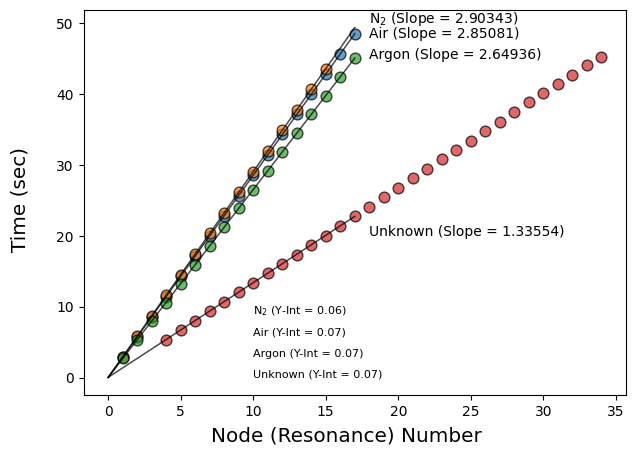

In [105]:
# @title
# Looking at the Chirp sound data resonance peak finding, it is clear that this algorithm is also picking out the spike when the gas flow stops.
# This spike is at the end of the sound data, so before plotting and performing a linear regression, remove the last row of data (the 'spike' data, which is NOT a resonance)

# Deleting the last row from gas 2, 3 and 4 dataframes (gas 1 did not pick the gas flow 'spike' as the last data point - see plot above)
gas2_restable1 = gas2_restable.drop(gas2_restable.index[len(gas2_restable)-1])
gas3_restable1 = gas3_restable.drop(gas3_restable.index[len(gas3_restable)-1])
gas4_restable1 = gas4_restable.drop(gas4_restable.index[len(gas4_restable)-1])

# Initialize plot layout
fig, ax = plt.subplots(figsize = (7, 5))

# Set general font size
plt.rcParams['font.size'] = '12'

# Set X and Y Axis Labels for subPlots
fig.supxlabel('Node (Resonance) Number')
fig.supylabel('Time (sec)')

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(10)

# Add scatter plots
ax.scatter(gas1_restable['Node'], gas1_restable['Time (sec)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas2_restable1['Node'], gas2_restable1['Time (sec)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas3_restable1['Node'], gas3_restable1['Time (sec)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas4_restable1['Node']+3, gas4_restable1['Time (sec)'], s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b1c, a1c = np.polyfit(gas1_restable['Node'], gas1_restable['Time (sec)'], deg=1)
b2c, a2c = np.polyfit(gas2_restable1['Node'], gas2_restable1['Time (sec)'], deg=1)
b3c, a3c = np.polyfit(gas3_restable1['Node'], gas3_restable1['Time (sec)'], deg=1)
b4c, a4c = np.polyfit(gas4_restable1['Node']+3, gas4_restable1['Time (sec)'], deg=1)

# Create sequence of 26 numbers from 0 to 25
xseq = np.linspace(0, 17, num=18)

# Plot regression line
ax.plot(xseq, a1c + b1c * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a2c + b2c * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a3c + b3c * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a4c + b4c * xseq, alpha=0.7, color="k", lw=1.1)

# Annotate Plot with text
ax.text(18, 48, 'Air (Slope = {})'.format(round(b1c,5)), fontsize=10)
ax.text(18, 50, 'N$_2$ (Slope = {})'.format(round(b2c,5)), fontsize=10)
ax.text(18, 45, 'Argon (Slope = {})'.format(round(b3c,5)), fontsize=10)
ax.text(18, 20, 'Unknown (Slope = {})'.format(round(b4c,5)), fontsize=10)

# Annotate Plot with text
ax.text(10, 6, 'Air (Y-Int = {})'.format(round(a1c,2)), fontsize=8)
ax.text(10, 9, 'N$_2$ (Y-Int = {})'.format(round(a2c,2)), fontsize=8)
ax.text(10, 3, 'Argon (Y-Int = {})'.format(round(a3c,2)), fontsize=8)
ax.text(10, 0, 'Unknown (Y-Int = {})'.format(round(a4c,2)), fontsize=8)

#Show the plot in this notebook
plt.show()

In [106]:
# @title
# Error Analysis - Chirp Sound Data (Time)

# Linear Regression using SciPy Stat Library
linearregression_gas1_chirp_time = stats.linregress(gas1_restable['Node'], gas1_restable['Time (sec)'])
linearregression_gas2_chirp_time = stats.linregress(gas2_restable1['Node'], gas2_restable1['Time (sec)'])
linearregression_gas3_chirp_time = stats.linregress(gas3_restable1['Node'], gas3_restable1['Time (sec)'])
linearregression_gas4_chirp_time = stats.linregress(gas4_restable1['Node']+3, gas4_restable1['Time (sec)'])

# Print R-squared values for each of the linear regression fits
print(f"Linear Regression R-squared")
print(f"Gas 1 - {linearregression_gas1_chirp_time.rvalue**2:.6f}")
print(f"Gas 2 - {linearregression_gas2_chirp_time.rvalue**2:.6f}")
print(f"Gas 3 - {linearregression_gas3_chirp_time.rvalue**2:.6f}")
print(f"Gas 4 - {linearregression_gas4_chirp_time.rvalue**2:.6f}")
print(f" ")


# Two-sided inverse Students t-distribution, p - probability, df - degrees of freedom
tinv = lambda p, df: abs(t.ppf(p/2, df))

print(f"95% Confidence Level (+/-)")
print(f"__________________________")
ts1 = tinv(0.05, len(gas1_restable['Node'])-2)
print(f"Gas 1")
print(f"slope = {linearregression_gas1_chirp_time.slope:.5f} +/- {ts1*linearregression_gas1_chirp_time.stderr:.5f}")
print(f"y-intercept = {linearregression_gas1_chirp_time.intercept:.5f}"
      f" +/- {ts1*linearregression_gas1_chirp_time.intercept_stderr:.5f}")
print(f" ")

ts2 = tinv(0.05, len(gas2_restable1['Node'])-2)
print(f"Gas 2")
print(f"slope = {linearregression_gas2_chirp_time.slope:.5f} +/- {ts1*linearregression_gas2_chirp_time.stderr:.5f}")
print(f"y-intercept = {linearregression_gas2_chirp_time.intercept:.5f}"
      f" +/- {ts1*linearregression_gas2_chirp_time.intercept_stderr:.5f}")
print(f" ")

ts3 = tinv(0.05, len(gas3_restable1['Node'])-2)
print(f"Gas 3")
print(f"slope = {linearregression_gas3_chirp_time.slope:.5f} +/- {ts1*linearregression_gas3_chirp_time.stderr:.5f}")
print(f"y-intercept = {linearregression_gas3_chirp_time.intercept:.5f}"
      f" +/- {ts1*linearregression_gas3_chirp_time.intercept_stderr:.5f}")
print(f" ")

ts4 = tinv(0.05, len(gas4_restable1['Node'])-2)
print(f"Gas 4")
print(f"slope = {linearregression_gas4_chirp_time.slope:.5f} +/- {ts1*linearregression_gas4_chirp_time.stderr:.5f}")
print(f"y-intercept = {linearregression_gas4_chirp_time.intercept:.5f}"
      f" +/- {ts1*linearregression_gas4_chirp_time.intercept_stderr:.5f}")
print(f" ")


Linear Regression R-squared
Gas 1 - 0.999996
Gas 2 - 0.999998
Gas 3 - 0.999997
Gas 4 - 0.999982
 
95% Confidence Level (+/-)
__________________________
Gas 1
slope = 2.85081 +/- 0.00308
y-intercept = 0.07449 +/- 0.03156
 
Gas 2
slope = 2.90343 +/- 0.00257
y-intercept = 0.05724 +/- 0.02334
 
Gas 3
slope = 2.64936 +/- 0.00269
y-intercept = 0.06632 +/- 0.02754
 
Gas 4
slope = 1.33554 +/- 0.00223
y-intercept = 0.07449 +/- 0.04676
 


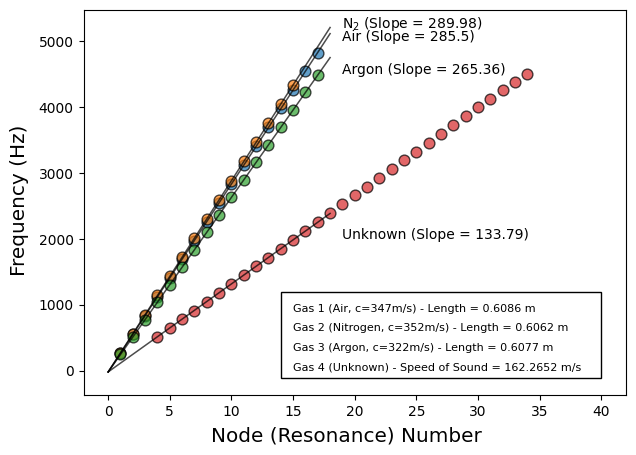

In [111]:
# @title
# Add a Column with Resonance Frequency (Hz) to the Chirp Sound DataFrame (by Convert Chirp Resonance Times (sec) to Frequencies (Hz)).
gas1_restable['Frequency (Hz)'] = (gas1_restable['Time (sec)']-0.230)*(5512.5/55.125)
gas2_restable1['Frequency (Hz)'] = (gas2_restable1['Time (sec)']-0.230)*(5512.5/55.125)
gas3_restable1['Frequency (Hz)'] = (gas3_restable1['Time (sec)']-0.230)*(5512.5/55.125)
gas4_restable1['Frequency (Hz)'] = (gas4_restable1['Time (sec)']-0.230)*(5512.5/55.125)

# Initialize plot layout
fig, ax = plt.subplots(figsize = (7, 5))

# Set general font size
plt.rcParams['font.size'] = '12'

# Set X and Y Axis Labels for subPlots
fig.supxlabel('Node (Resonance) Number')
fig.supylabel('Frequency (Hz)')

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(10)

# Add scatter plots
ax.scatter(gas1_restable['Node'], gas1_restable['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas2_restable1['Node'], gas2_restable1['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas3_restable1['Node'], gas3_restable1['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")
ax.scatter(gas4_restable1['Node']+3, gas4_restable1['Frequency (Hz)'], s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b1c, a1c = np.polyfit(gas1_restable['Node'], gas1_restable['Frequency (Hz)'], deg=1)
b2c, a2c = np.polyfit(gas2_restable1['Node'], gas2_restable1['Frequency (Hz)'], deg=1)
b3c, a3c = np.polyfit(gas3_restable1['Node'], gas3_restable1['Frequency (Hz)'], deg=1)
b4c, a4c = np.polyfit(gas4_restable1['Node']+3, gas4_restable1['Frequency (Hz)'], deg=1)

# Create sequence of 26 numbers from 0 to 25
xseq = np.linspace(0, 18, num=19)

# Plot regression line
ax.plot(xseq, a1c + b1c * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a2c + b2c * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a3c + b3c * xseq, alpha=0.7, color="k", lw=1.1)
ax.plot(xseq, a4c + b4c * xseq, alpha=0.7, color="k", lw=1.1)

#Annotate Plot with text - Slope
ax.text(19, 5000, 'Air (Slope = {})'.format(round(b1,2)), fontsize=10)
ax.text(19, 5200, 'N$_2$ (Slope = {})'.format(round(b2,2)), fontsize=10)
ax.text(19, 4500, 'Argon (Slope = {})'.format(round(b3,2)), fontsize=10)
ax.text(19, 2000, 'Unknown (Slope = {})'.format(round(b4,2)), fontsize=10)

# Speed of Sound for Gases 1 (air), 2 (Ar) and 3 (CO2) in m/s.
c1 = 347
c2 = 352
c3 = 322

# Determine the Acoustic Interferometer resonance tube length (L) for Gases 1 (air), 2 (Ar) and 3 (CO2) in m/s (from chirp sound data).
l1c = c1/(2*b1c)
l2c = c2/(2*b2c)
l3c = c3/(2*b3c)

# Determine the Speed of Sound (c) for Gases 4 (R134a) in m/s.
c4c = ((l1c+l2c+l3c)/3)*(2*b4c)

# Annotate Plot with text - Length of Acoustic Interferometer Tube and Speed of Sound for Gas 4.
ax.text(15, 900, 'Gas 1 (Air, c=347m/s) - Length = {} m'.format(round(l1c,4)), fontsize=8)
ax.text(15, 600, 'Gas 2 (Nitrogen, c=352m/s) - Length = {} m'.format(round(l2c,4)), fontsize=8)
ax.text(15, 300, 'Gas 3 (Argon, c=322m/s) - Length = {} m'.format(round(l3c,4)), fontsize=8)
ax.text(15, 0, 'Gas 4 (Unknown) - Speed of Sound = {} m/s'.format(round(c4c,4)), fontsize=8)

# Create a Rectangle patch
rect = patches.Rectangle((14, -100), 26, 1300, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

#Show the plot in this notebook
plt.show()

In [112]:
# @title
# Error Analysis - Chirp Sound Data (Frequency)

# Linear Regression using SciPy Stat Library
linearregression_gas1_chirp_freq = stats.linregress(gas1_restable['Node'], gas1_restable['Frequency (Hz)'])
linearregression_gas2_chirp_freq = stats.linregress(gas2_restable1['Node'], gas2_restable1['Frequency (Hz)'])
linearregression_gas3_chirp_freq = stats.linregress(gas3_restable1['Node'], gas3_restable1['Frequency (Hz)'])
linearregression_gas4_chirp_freq = stats.linregress(gas4_restable1['Node']+3, gas4_restable1['Frequency (Hz)'])

# Print R-squared values for each of the linear regression fits
print(f"Linear Regression R-squared")
print(f"Gas 1 - {linearregression_gas1_chirp_freq.rvalue**2:.6f}")
print(f"Gas 2 - {linearregression_gas2_chirp_freq.rvalue**2:.6f}")
print(f"Gas 3 - {linearregression_gas3_chirp_freq.rvalue**2:.6f}")
print(f"Gas 4 - {linearregression_gas4_chirp_freq.rvalue**2:.6f}")
print(f" ")


# Two-sided inverse Students t-distribution, p - probability, df - degrees of freedom
tinv = lambda p, df: abs(t.ppf(p/2, df))

print(f"95% Confidence Level (+/-)")
print(f"__________________________")
ts1 = tinv(0.05, len(gas1_restable['Node'])-2)
print(f"Gas 1")
print(f"slope = {linearregression_gas1_chirp_freq.slope:.5f} +/- {ts1*linearregression_gas1_chirp_freq.stderr:.5f}")
print(f"y-intercept = {linearregression_gas1_chirp_freq.intercept:.5f}"
      f" +/- {ts1*linearregression_gas1_chirp_freq.intercept_stderr:.5f}")
print(f" ")

ts2 = tinv(0.05, len(gas2_restable1['Node'])-2)
print(f"Gas 2")
print(f"slope = {linearregression_gas2_chirp_freq.slope:.5f} +/- {ts1*linearregression_gas2_chirp_freq.stderr:.5f}")
print(f"y-intercept = {linearregression_gas2_chirp_freq.intercept:.5f}"
      f" +/- {ts1*linearregression_gas2_chirp_freq.intercept_stderr:.5f}")
print(f" ")

ts3 = tinv(0.05, len(gas3_restable1['Node'])-2)
print(f"Gas 3")
print(f"slope = {linearregression_gas3_chirp_freq.slope:.5f} +/- {ts1*linearregression_gas3_chirp_freq.stderr:.5f}")
print(f"y-intercept = {linearregression_gas3_chirp_freq.intercept:.5f}"
      f" +/- {ts1*linearregression_gas3_chirp_freq.intercept_stderr:.5f}")
print(f" ")

ts4 = tinv(0.05, len(gas4_restable1['Node'])-2)
print(f"Gas 4")
print(f"slope = {linearregression_gas4_chirp_freq.slope:.5f} +/- {ts1*linearregression_gas4_chirp_freq.stderr:.5f}")
print(f"y-intercept = {linearregression_gas4_chirp_freq.intercept:.5f}"
      f" +/- {ts1*linearregression_gas4_chirp_freq.intercept_stderr:.5f}")
print(f" ")

Linear Regression R-squared
Gas 1 - 0.999996
Gas 2 - 0.999998
Gas 3 - 0.999997
Gas 4 - 0.999982
 
95% Confidence Level (+/-)
__________________________
Gas 1
slope = 285.08088 +/- 0.30801
y-intercept = -15.55147 +/- 3.15618
 
Gas 2
slope = 290.34286 +/- 0.25676
y-intercept = -17.27619 +/- 2.33445
 
Gas 3
slope = 264.93627 +/- 0.26873
y-intercept = -16.36765 +/- 2.75369
 
Gas 4
slope = 133.55363 +/- 0.22266
y-intercept = -15.55121 +/- 4.67583
 
